In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns

In [21]:
checkpoints_eoc = pd.read_csv('../Data/checkpoints_eoc.csv')
checkpoints_pulse = pd.read_csv('../Data/checkpoints_pulse.csv')
items = pd.read_csv('../Data/items.csv')
media_views = pd.read_csv('../Data/media_views.csv')
page_views = pd.read_csv('../Data/page_views.csv')
responses = pd.read_csv('../Data/responses.csv')

/tmp/ipykernel_11690/518263414.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  page_views = pd.read_csv('../Data/page_views.csv')
/tmp/ipykernel_11690/518263414.py:6: DtypeWarning: Columns (34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  responses = pd.read_csv('../Data/responses.csv')


In [22]:
# Extract the 'studentid' column as sets
ids1 = set(checkpoints_eoc['student_id'])
ids2 = set(checkpoints_pulse['student_id'])
ids3 = set(media_views['student_id'])
ids4 = set(page_views['student_id'])
ids5 = set(responses['student_id'])

# Find the common 'studentid' in all DataFrames
common_ids = ids1.intersection(ids2, ids3, ids4, ids5)

# To see the common student IDs
print(common_ids)

# If you just want to know whether there are any common IDs and how many
print(f"There are {len(common_ids)} students present in all DataFrames.")

{'9bc5dcd2-8f6b-4d70-918e-ad5d0f795ce6', '8476c87b-dc78-41cc-beb0-0d278e230671', '5366fd5d-8560-4a7a-ab1d-6cd27ed96bef', '6bf771cc-98d9-4d66-9e95-3d5d794088e9', '001824fb-a2fd-431d-aef6-7a1250d97a62', '2b52c7c7-844f-4e84-9007-203a1b72e96b', '2995b8ed-3884-4ccb-a57e-f1003f786842', 'f03fcac7-b005-4ba0-952e-b8616cbaa093', '2dc53ab2-0169-4c9d-8b09-b9ee5abdcf41', '3973b992-231b-43a0-9714-b99ab8746bd1', '8f3faf8d-8c56-4587-81c4-d6eb2cc5a4c7', '7258a4d9-3c15-49e0-a185-713f9f04510a', 'f1df3150-ad4c-480e-b3ef-e3494116401d', '72419be6-b3b7-4ceb-8361-ad1cc116eb98', 'b5018344-94aa-47c1-931e-0bbe779d10c8', 'fc8583cc-315d-4240-a516-ab7e4640ccaa', 'a51af53e-6e4c-4651-832d-e7349e808a6d', '108b5ee7-3cab-468b-b937-535d91da2fd5', '1bacdb33-5165-44c1-9aa5-b6a904e6c463', 'dec3cb78-80e0-4ead-b700-404b79b49364', 'cdff841b-378d-40e7-a2da-c64c3e967d5e', '2ed350ca-ed46-4157-9383-52299f08733b', 'dc28e7ae-4a4a-494c-bffa-a7036fff14cb', 'c189d1aa-2a19-4a55-822d-9e5022fdf89e', 'a82791eb-61d5-4496-a7b8-d8112e081649',

In [29]:
filtered_df1 = checkpoints_eoc[checkpoints_eoc['student_id'].isin(common_ids)]
filtered_df1['f1_score'] = 2 * ((filtered_df1['n_correct'] / filtered_df1['n_attempt']) * (filtered_df1['n_correct'] / filtered_df1['n_possible'])) / ((filtered_df1['n_correct'] / filtered_df1['n_attempt']) + (filtered_df1['n_correct'] / filtered_df1['n_possible']))
filtered_df1 = filtered_df1.drop(columns=['n_correct', 'n_attempt', 'n_possible', 'EOC', 'book'])

filtered_df2 = checkpoints_pulse[checkpoints_pulse['student_id'].isin(common_ids)]
filtered_df2 = filtered_df2.drop(columns=['release', 'book'])
filtered_df2['chapter_number'] = filtered_df2['chapter_number'] - 1

filtered_df3 = media_views[media_views['student_id'].isin(common_ids)]
filtered_df3 = filtered_df3.drop(columns=['book', 'release', 'chapter', 'page', 'dt_started', 'dt_last_event'])

filtered_df4 = page_views[page_views['student_id'].isin(common_ids)]
filtered_df4 = filtered_df4.dropna(subset=['chapter_number'])
filtered_df4['chapter_number'] = filtered_df4['chapter_number'].astype(int)
filtered_df4['section_number'] = filtered_df4['section_number'].astype(int)
filtered_df4 = filtered_df4.drop(columns=['book', 'release', 'chapter', 'page'])

filtered_df5 = responses[responses['student_id'].isin(common_ids)]

combined_df = pd.merge(left=filtered_df1, right=filtered_df2, on=['student_id', 'chapter_number', 'class_id'], how='inner')

/tmp/ipykernel_11690/1085180329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df1['f1_score'] = 2 * ((filtered_df1['n_correct'] / filtered_df1['n_attempt']) * (filtered_df1['n_correct'] / filtered_df1['n_possible'])) / ((filtered_df1['n_correct'] / filtered_df1['n_attempt']) + (filtered_df1['n_correct'] / filtered_df1['n_possible']))


In [30]:
# Step 2: Pivot the table
pivot_df = combined_df.pivot_table(index=['student_id', 'class_id', 'chapter_number', 'f1_score', 'institution_id'],
                          columns='construct', values='response', aggfunc='first').reset_index()

# Step 3: Flatten the DataFrame
pivot_df.columns.name = None  # Removes the name of the index for columns

# Step 4: Rename the columns (optional)
pivot_df = pivot_df.rename(columns={
    'Cost': 'Cost_Response',
    'Expectancy': 'Expectancy_Response',
    'Intrinsic Value': 'Intrinsic_Value_Response',
    'Utility Value': 'Utility_Value_Response'
})
pivot_df

,student_id,class_id,chapter_number,f1_score,institution_id,Cost_Response,Expectancy_Response,Intrinsic_Value_Response,Utility_Value_Response
0,001824fb-a2fd-431d-aef6-7a1250d97a62,074123e7-cd90-4500-86fe-286aaa733bf5,1,0.897436,292cff87-3c74-4e94-8622-233afb0427dd,2.0,5.0,5.0,4.0
1,001824fb-a2fd-431d-aef6-7a1250d97a62,074123e7-cd90-4500-86fe-286aaa733bf5,2,0.682243,292cff87-3c74-4e94-8622-233afb0427dd,4.0,4.0,4.0,4.0
2,001824fb-a2fd-431d-aef6-7a1250d97a62,074123e7-cd90-4500-86fe-286aaa733bf5,3,0.642570,292cff87-3c74-4e94-8622-233afb0427dd,4.0,4.0,4.0,4.0
3,001824fb-a2fd-431d-aef6-7a1250d97a62,074123e7-cd90-4500-86fe-286aaa733bf5,4,0.519403,292cff87-3c74-4e94-8622-233afb0427dd,4.0,4.0,4.0,4.0
4,001824fb-a2fd-431d-aef6-7a1250d97a62,074123e7-cd90-4500-86fe-286aaa733bf5,5,0.640523,292cff87-3c74-4e94-8622-233afb0427dd,5.0,3.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...
1587,fe5182ec-6732-402e-91f6-a5ddec5107ba,7a987176-7e55-45b5-a715-7f56c59d5f49,1,0.645161,94a809a9-a0ef-4c47-8d96-3a5ad76f674b,4.0,4.0,5.0,5.0
1588,fe5182ec-6732-402e-91f6-a5ddec5107ba,7a987176-7e55-45b5-a715-7f56c59d5f49,2,0.663551,94a809a9-a0ef-4c47-8d96-3a5ad76f674b,4.0,2.0,3.0,4.0
1589,fe5182ec-6732-402e-91f6-a5ddec5107ba,7a987176-7e55-45b5-a715-7f56c59d5f49,3,0.362934,94a809a9-a0ef-4c47-8d96-3a5ad76f674b,4.0,1.0,3.0,2.0
1590,fe5182ec-6732-402e-91f6-a5ddec5107ba,7a987176-7e55-45b5-a715-7f56c59d5f49,7,0.888889,94a809a9-a0ef-4c47-8d96-3a5ad76f674b,5.0,3.0,4.0,4.0


In [44]:
merged_df = pd.merge(left=pivot_df, right=filtered_df4, on=['student_id', 'chapter_number', 'class_id', 'institution_id'], how='inner')

merged_df.to_csv('../Data/forGPT.csv', index=False)

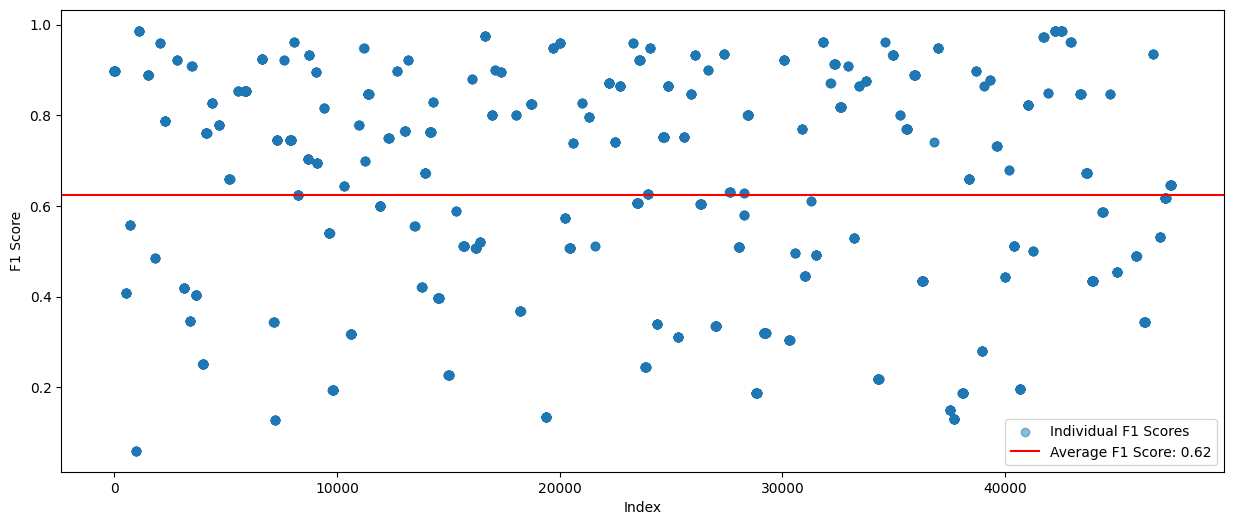

In [42]:
df_filtered = merged_df[merged_df['chapter_number'] == 1]
# Assuming df_filtered is your DataFrame with the filtered data where 'chapter_number' == 1
average_f1_score = df_filtered['f1_score'].mean()

# Plotting the individual f1_scores as a scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(df_filtered.index, df_filtered['f1_score'], alpha=0.5, label='Individual F1 Scores')

# Plotting the average line
plt.axhline(y=average_f1_score, color='r', linestyle='-', label=f'Average F1 Score: {average_f1_score:.2f}')

# Labeling the axes
plt.xlabel('Index')
plt.ylabel('F1 Score')

# Adding a legend
plt.legend()

# Show the plot
plt.show()


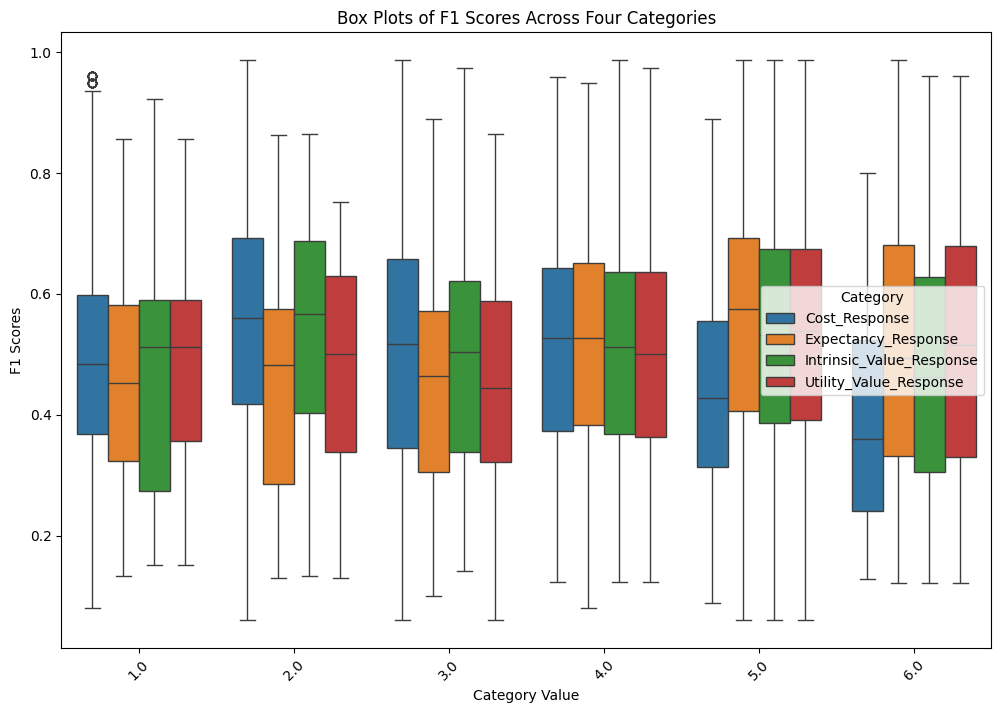

In [32]:
# Assuming df is your DataFrame
# Melt the DataFrame to long format where each category becomes a value under a new 'category' column
long_df = merged_df.melt(id_vars='f1_score', value_vars=['Cost_Response', 'Expectancy_Response', 'Intrinsic_Value_Response', 'Utility_Value_Response'],
                  var_name='Category', value_name='Value')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Value', y='f1_score', hue='Category', data=long_df)
plt.xlabel('Category Value')
plt.ylabel('F1 Scores')
plt.title('Box Plots of F1 Scores Across Four Categories')
plt.legend(title='Category')
plt.xticks(rotation=45)  # Helpful if you have many categories or the labels are long
plt.show()

In [28]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform ANOVA for 'category1'
anova_results = ols('f1_score ~ C(Cost_Response)', data=merged_df).fit()
anova_table = sm.stats.anova_lm(anova_results, typ=2)
print(anova_table)

# Post-hoc testing for 'category1'
tukey_results = pairwise_tukeyhsd(endog=merged_df['f1_score'], groups=merged_df['Cost_Response'], alpha=0.05)
print(tukey_results)


                       sum_sq       df          F  PR(>F)
C(Cost_Response)    65.840604      5.0  400.28837     0.0
Residual          1540.580028  46831.0        NaN     NaN
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   1.0    2.0   0.0558    0.0  0.0464  0.0651   True
   1.0    3.0    0.024    0.0  0.0148  0.0332   True
   1.0    4.0   0.0306    0.0  0.0212    0.04   True
   1.0    5.0  -0.0203    0.0 -0.0323 -0.0083   True
   1.0    6.0  -0.1337    0.0 -0.1487 -0.1187   True
   1.0    nan  -0.0234 0.0258 -0.0451 -0.0016   True
   2.0    3.0  -0.0318    0.0 -0.0385 -0.0251   True
   2.0    4.0  -0.0252    0.0 -0.0322 -0.0181   True
   2.0    5.0  -0.0761    0.0 -0.0863 -0.0659   True
   2.0    6.0  -0.1895    0.0 -0.2031 -0.1758   True
   2.0    nan  -0.0791    0.0    -0.1 -0.0583   True
   3.0    4.0   0.0066 0.0599 -0.0001  0.0134  False
   3.0    5.0  -0.0443    0.0 -

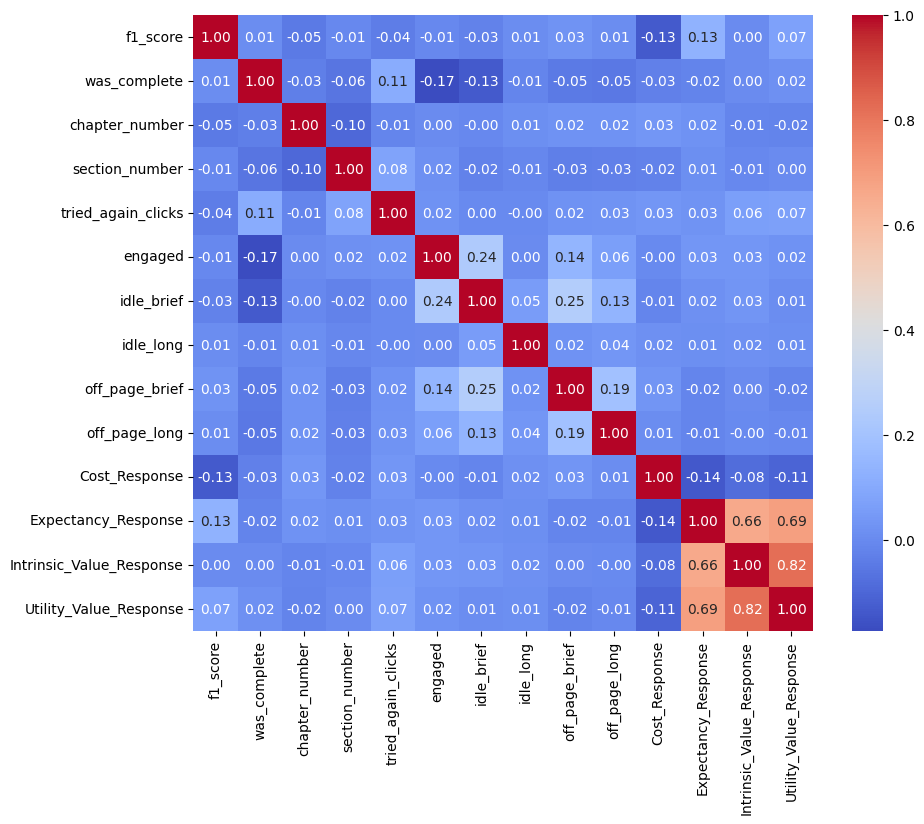

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_df = merged_df[['f1_score','was_complete', 'chapter_number', 'section_number', 'tried_again_clicks','engaged','idle_brief','idle_long','off_page_brief','off_page_long', 'Cost_Response', 'Expectancy_Response', 'Intrinsic_Value_Response', 'Utility_Value_Response']]
# Assuming 'pivot_df' is your DataFrame from the previous steps

# Calculate correlations between the numerical variables
corr = numerical_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Show plot
plt.show()